In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic

In [52]:

import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

train_data = pd.read_csv('/content/train_.csv')
test_data = pd.read_csv('/content/test_.csv')
pincodes_data = pd.read_csv('/content/pincodes_cleaned.csv')


pincodes_data = pincodes_data.drop_duplicates(subset='Pincode', keep='first')

pincode_dict = pincodes_data.set_index('Pincode')[['Latitude', 'Longitude']].to_dict('index')


In [53]:
def get_coordinates(pincode, coord_type):
    try:
        return pincode_dict[pincode][coord_type]
    except KeyError:
        return np.nan

In [54]:

train_data['pickup_lat'] = train_data['pickup_pin_code'].apply(get_coordinates, coord_type='Latitude')
train_data['pickup_lon'] = train_data['pickup_pin_code'].apply(get_coordinates, coord_type='Longitude')
train_data['drop_lat'] = train_data['drop_pin_code'].apply(get_coordinates, coord_type='Latitude')
train_data['drop_lon'] = train_data['drop_pin_code'].apply(get_coordinates, coord_type='Longitude')


In [55]:
test_data['pickup_lat'] = test_data['pickup_pin_code'].apply(get_coordinates, coord_type='Latitude')
test_data['pickup_lon'] = test_data['pickup_pin_code'].apply(get_coordinates, coord_type='Longitude')
test_data['drop_lat'] = test_data['drop_pin_code'].apply(get_coordinates, coord_type='Latitude')
test_data['drop_lon'] = test_data['drop_pin_code'].apply(get_coordinates, coord_type='Longitude')

In [56]:
# Feature Engineering - Calculate geodesic distance
def calculate_distance(row):
    try:
        return geodesic((row['pickup_lat'], row['pickup_lon']), (row['drop_lat'], row['drop_lon'])).km
    except ValueError:
        return np.nan

train_data['distance_km'] = train_data.apply(calculate_distance, axis=1)
test_data['distance_km'] = test_data.apply(calculate_distance, axis=1)

/usr/local/lib/python3.10/dist-packages/geopy/point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)
/usr/local/lib/python3.10/dist-packages/geopy/point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


In [57]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_data['account_mode'] = label_encoder.fit_transform(train_data['account_mode'])
test_data['account_mode'] = label_encoder.transform(test_data['account_mode'])

In [58]:

train_data['order_shipped_date'] = pd.to_datetime(train_data['order_shipped_date'])
train_data['order_delivered_date'] = pd.to_datetime(train_data['order_delivered_date'])
train_data['delivery_time'] = (train_data['order_delivered_date'] - train_data['order_shipped_date']).dt.days

In [59]:
test_data['order_shipped_date'] = pd.to_datetime(test_data['order_shipped_date'])

In [60]:
# Dropping unused columns
train_data.drop(['id', 'order_delivered_date', 'order_shipped_date'], axis=1, inplace=True)
test_ids = test_data['id']
test_data.drop(['id', 'order_shipped_date'], axis=1, inplace=True)

In [61]:
# Define input features and target variable
X = train_data.drop('delivery_time', axis=1)
y = train_data['delivery_time']
X_test = test_data.copy()

In [62]:
# Splitting data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
import xgboost as xgb
print(xgb.__version__)

2.1.3


In [63]:
import numpy as np


X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



X_train shape: (1120664, 12), y_train shape: (1120664,)
X_val shape: (280167, 12), y_val shape: (280167,)


In [64]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    random_state=42,
    eval_metric="rmse"  # Define evaluation metric here
)

In [42]:
# invalid latitude/longitude
def is_valid_coordinate(coord):
    try:
        # checking for valid coordinates
        coord = float(coord)
        return -90 <= coord <= 90 or -180 <= coord <= 180
    except ValueError:
        return False

invalid_lat_rows = pincodes_data[~pincodes_data['Latitude'].apply(is_valid_coordinate)]
invalid_lon_rows = pincodes_data[~pincodes_data['Longitude'].apply(is_valid_coordinate)]

print("Invalid Latitude Rows:")
print(invalid_lat_rows)
print("Invalid Longitude Rows:")
print(invalid_lon_rows)


Invalid Latitude Rows:
                   CircleName                     RegionName  \
201      Uttar Pradesh Circle                  Kanpur Region   
311     Andhra Pradesh Circle              Vijayawada Region   
312          Telangana Circle          Hyderabad City Region   
313          Telangana Circle          Hyderabad City Region   
315          Telangana Circle          Hyderabad City Region   
...                       ...                            ...   
149087       Tamilnadu Circle  Central Region, Trichirapalli   
151031          Punjab Circle             DivReportingCircle   
152052       Tamilnadu Circle     Western Region, Coimbatore   
156538   Uttar Pradesh Circle                Varanasi Region   
157002   Uttar Pradesh Circle                Varanasi Region   

                   DivisionName                       OfficeName  Pincode  \
201          Kanpur HO Division                       NDC Kanpur   208001   
311              Gudur Division   VIKRAMASIMHAPURI UNI

In [43]:
# Replace invalid values with NaN
pincodes_data['Latitude'] = pincodes_data['Latitude'].apply(lambda x: float(x) if is_valid_coordinate(x) else np.nan)
pincodes_data['Longitude'] = pincodes_data['Longitude'].apply(lambda x: float(x) if is_valid_coordinate(x) else np.nan)

# representing missing values with the mean/median
pincodes_data['Latitude'].fillna(pincodes_data['Latitude'].mean(), inplace=True)
pincodes_data['Longitude'].fillna(pincodes_data['Longitude'].mean(), inplace=True)


<ipython-input-43-6973806dfb4c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pincodes_data['Latitude'].fillna(pincodes_data['Latitude'].mean(), inplace=True)
<ipython-input-43-6973806dfb4c>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [44]:
from sklearn.impute import KNNImputer

# KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
pincodes_data[['Latitude', 'Longitude']] = knn_imputer.fit_transform(pincodes_data[['Latitude', 'Longitude']])


In [47]:
import pandas as pd
import numpy as np

# handling the inconsistencies in the dataset (pinocdes.csv)


file_path = "pincodes.csv"  # Replace with the correct file path


    pincodes_data = pd.read_csv(file_path, dtype={"longitude": str, "latitude": str})
except Exception as e:
    print(f"Error reading the file: {e}")
    exit()


def safe_float_conversion(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

# Applying function to longitude and latitude coulmn
pincodes_data["Longitude"] = pincodes_data["Longitude"].apply(safe_float_conversion)
pincodes_data["Latitude"] = pincodes_data["Latitude"].apply(safe_float_conversion)

pincodes_data["Longitude"].fillna(0.0, inplace=True)
pincodes_data["Latitude"].fillna(0.0, inplace=True)

# Dropping rows with "Na"  values
 # pincodes_data.dropna(subset=["longitude", "latitude"], inplace=True)

# Saving clean data to a new file
output_file = "pincodes_cleaned.csv"
pincodes_data.to_csv(output_file, index=False)

print(f"Cleaned data saved to {output_file}")


<ipython-input-47-5fbbb777c821>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pincodes_data["Longitude"].fillna(0.0, inplace=True)
<ipython-input-47-5fbbb777c821>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Cleaned data saved to pincodes_cleaned.csv


In [50]:
import pandas as pd
import numpy as np

file_path = "pincodes.csv"
#handling again

try:
    pincodes_data = pd.read_csv(file_path, dtype={"longitude": str, "latitude": str})
except Exception as e:
    print(f"Error reading the file: {e}")
    exit()

def safe_float_conversion(value):
    try:

        value = value.strip().rstrip('-')
        return float(value)
    except (ValueError, AttributeError):
        return np.nan


pincodes_data["Longitude"] = pincodes_data["Longitude"].apply(safe_float_conversion)
pincodes_data["Latitude"] = pincodes_data["Latitude"].apply(safe_float_conversion)


pincodes_data["Longitude"].fillna(0.0, inplace=True)
pincodes_data["Latitude"].fillna(0.0, inplace=True)



output_file = "pincodes_cleaned.csv"
pincodes_data.to_csv(output_file, index=False)

print(f"Cleaned data saved to {output_file}")


<ipython-input-50-e0999e707a1f>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pincodes_data["Longitude"].fillna(0.0, inplace=True)
<ipython-input-50-e0999e707a1f>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Cleaned data saved to pincodes_cleaned.csv


In [65]:
import xgboost as xgb
import numpy as np

# Converting data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Parameters for training
params = {
    "objective": "reg:squarederror",  # Using binary logistic for classification
    "eval_metric": "rmse",
    "random_state": 42,
}

# Initialize variables for early stopping
best_score = np.inf
early_stop_rounds = 20
no_improve_rounds = 0
best_iteration = 0

# Train with manual early stopping ->  as i was facing issues with early_stop
num_boost_round = 1000
for i in range(1, num_boost_round + 1):
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=i,
        evals=[(dval, "eval")],
        verbose_eval=False,
    )
    # Extracting current evaulation
    eval_score = model.eval(dval).split(":")[-1].strip()

    if float(eval_score) < best_score:
        best_score = float(eval_score)
        best_iteration = i
        no_improve_rounds = 0
    else:
        no_improve_rounds += 1

    if no_improve_rounds >= early_stop_rounds:
        print(f"Early stopping at iteration {best_iteration}")
        break


Early stopping at iteration 181


In [69]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [71]:
val_preds = model.predict(xgb.DMatrix(X_val), iteration_range=(0, best_iteration))
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Validation RMSE: {rmse}")


Validation RMSE: 0.4044994823289819


In [81]:
import xgboost as xgb

# Convert test data to DMatrix
test_dmatrix = xgb.DMatrix(X_test)

# Predicting on test data (Booster)
test_preds = model.predict(test_dmatrix)
test_data['predicted_exact_sla'] = np.round(test_preds).astype(int)


In [82]:
# Saving predictions
submission = pd.DataFrame({'id': test_ids, 'predicted_exact_sla': test_data['predicted_exact_sla']})
submission.to_csv('submission.csv', index=False)
print("Predictions saved to 'submission.csv'")



Predictions saved to 'submission.csv'


In [83]:
#  feature importance from the Booster model
feature_importance = model.get_score(importance_type='weight')

feature_importance_df = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance': feature_importance.values()
}).sort_values(by='Importance', ascending=False)


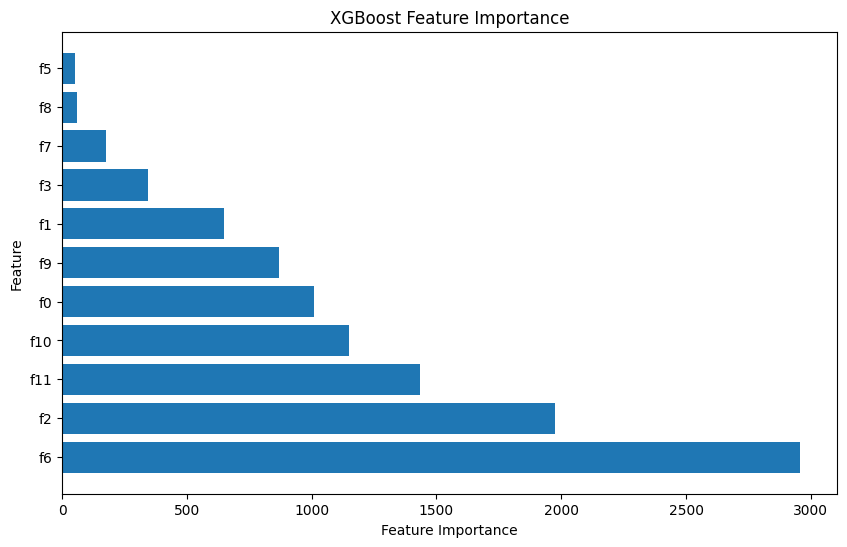

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()
